### Question 1

In [107]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

#### Part (a)

In [108]:
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')

<IPython.core.display.Javascript object>


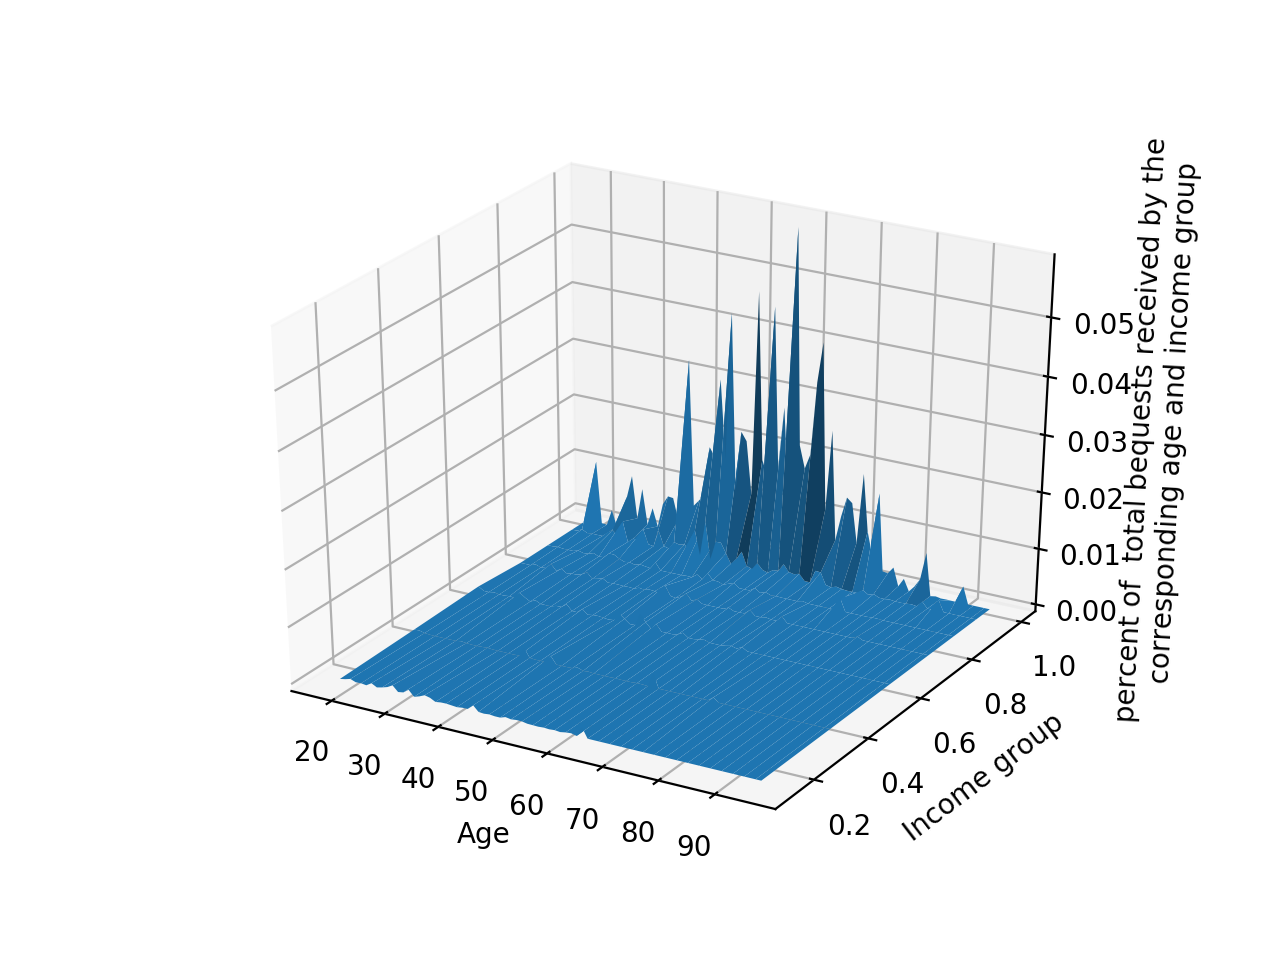

Text(0.5,0,'percent of  total bequests received by the \n corresponding age and income group')

In [109]:
ages_vec = np.arange(18, 96)
abils_midpt = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
y_mat, x_mat = np.meshgrid(abils_midpt, ages_vec)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_mat, y_mat, bq_data)
ax.set_xlabel("Age")
ax.set_ylabel("Income group")
ax.set_zlabel("percent of  total bequests received by the \n corresponding age and income group")

#### Part (b)

In [110]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(ages_vec)))
grid.fit(bq_data)

GridSearchCV(cv=sklearn.cross_validation.LeaveOneOut(n=78),
       error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([ 0.1    ,  0.10476, ...,  9.54548, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [111]:
grid.best_params_

{'bandwidth': 0.1}

So the optimal bandwidth is 0.1.

In [112]:
bandwidth = 0.1
prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(ages_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of ability type values
for abil, num_j in zip(abils_midpt, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

In [113]:
data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=bandwidth)
coords = np.vstack([item.ravel() for item in [x_mat, y_mat]])
BQkde = density(coords).reshape(x_mat.shape)
BQkde_scaled = BQkde / BQkde.sum()

<IPython.core.display.Javascript object>


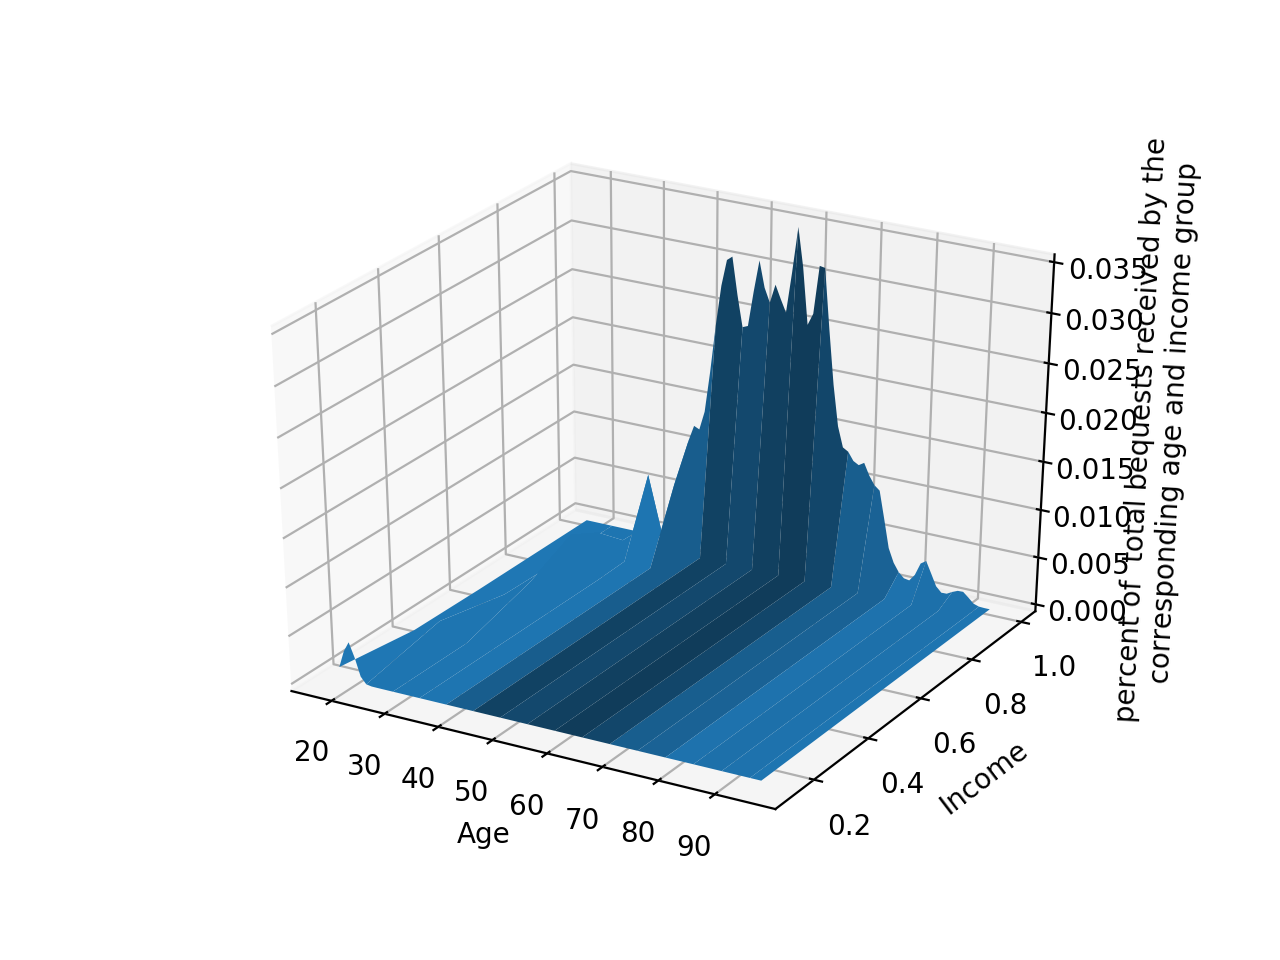

Text(0.5,0,'percent of  total bequests received by the \n corresponding age and income group')

In [114]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_mat, y_mat, BQkde_scaled, rstride=5)
ax.set_xlabel("Age")
ax.set_ylabel("Income")
ax.set_zlabel("percent of  total bequests received by the \n corresponding age and income group")

In [115]:
print('The estimated density for bequest recipients who are age 61 in the 6th lifetime \
income category is', BQkde_scaled[61-18+1, 5])

The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is 9.974022390823866e-07


#### Question 2

#### Part (a)

In [116]:
biden = pd.read_csv('biden.csv')
biden.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [117]:
import statsmodels.api as sm
biden["intera"] = biden["age"] * biden["educ"]
biden['constant'] = 1

In [118]:
reg = sm.OLS(endog=biden['biden'], exog=biden[['age', 'educ', 'intera', 'constant']], missing='drop')
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     10.74
Date:                Sun, 29 Apr 2018   Prob (F-statistic):           5.37e-07
Time:                        23:48:58   Log-Likelihood:                -8249.3
No. Observations:                1807   AIC:                         1.651e+04
Df Residuals:                    1803   BIC:                         1.653e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.6719      0.170      3.941      0.0

The marginal effect of age on Joe Biden thermometer rating conditional on education is E(biden) = 0.6719 - 0.0480 * educ. The magnitude is 0.0480. the direction is negative, which means that holding educ constant, the boosting effect of age on Joe Biden thermometer rating decreases as age increases. P = 0.000 indicates that the coefficient is statistically significant.

The supporting graph is at the end of this assignment. From the graphs, especially the bottom right one, we can know that the boosting effect of age on Joe Biden thermometer rating decreases as age increases. 

#### Part (b)

The marginal effect of age on Joe Biden thermometer rating conditional on education is E(biden) = 1.6574 - 0.0480 * age. The magnitude is 0.0480, the direction is negative, which means that holding age constant, the boosting effect of  education on Joe Biden thermometer rating decreases as education increases, and p-value = 0.02 indicates that the coefficient is statistically significant at 95% level. 

The supporting graph is at the end of this assignment. From the graphs, especially the bottom right one, we can know that the boosting effect of education on Joe Biden thermometer rating decreases as education increases.

#### Supporting Graphs for Question 2

<IPython.core.display.Javascript object>


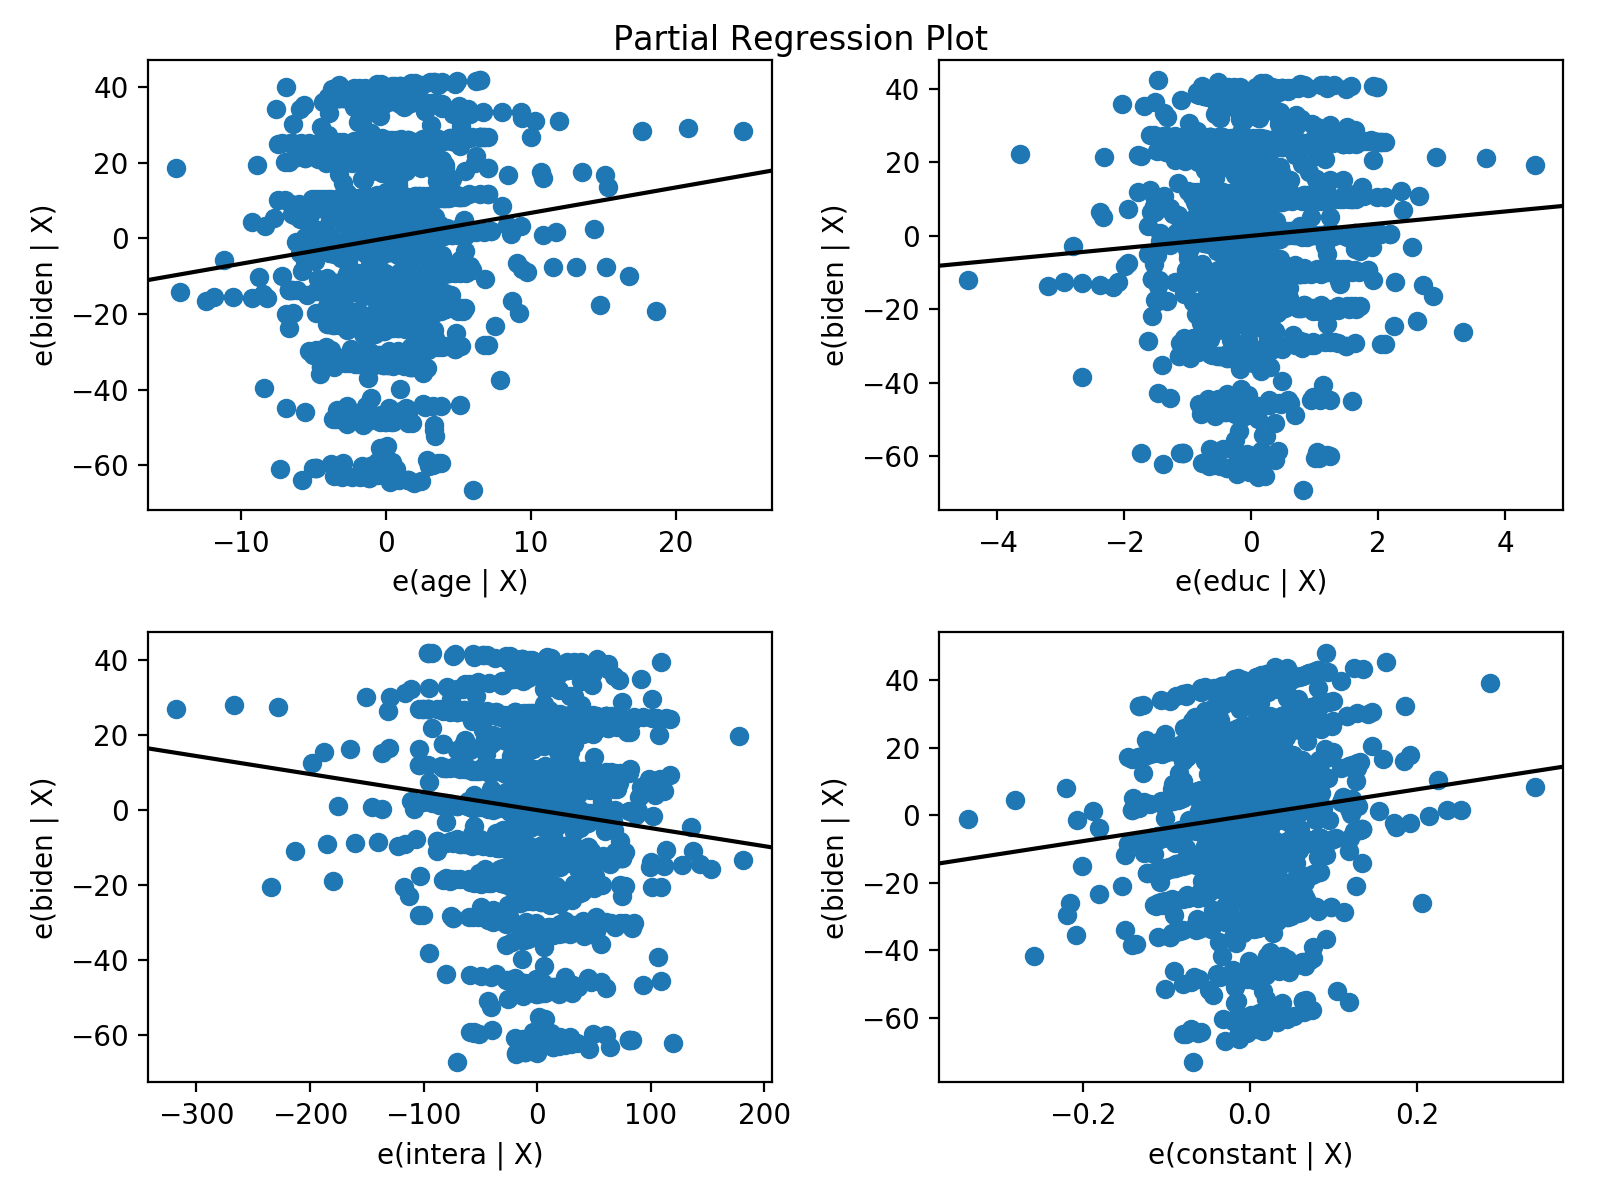

In [119]:
fig2 = plt.figure(figsize=(8,6))
fig2 = sm.graphics.plot_partregress_grid(results, fig=fig2)

#### References:    
Regression Plots. http://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html. Accessed April 29th, 2018.